In [1]:
import numpy as np
import pandas as pd
import scipy.io
import os,re
from M1S_tools import *

import matplotlib.pyplot as plt

plt.jet()

%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
Afz =  (27685, 170)
Afx =  (27685, 170)
Afy =  (27685, 170)
U matrix (27685, 170)
V matrix (170, 170)
S matrix (170, 170)
N node =  27685


<Figure size 640x480 with 0 Axes>

In [6]:
dataFolder = '/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents'

#read Af (where hp forces are along the hps)
df = pd.read_csv(dataFolder+'/influnce_matrix_files/OA_influence_matrices_all/Af_hp-07-Sep-2023.csv', header=None)
Afhp = np.array(df)
print('Afhp = ', Afhp.shape)

df = np.loadtxt('HP_xy.txt') #from Trupti email, in M1B
hpx = df[:,0]
hpy = df[:,1]

Afhp =  (27685, 6)


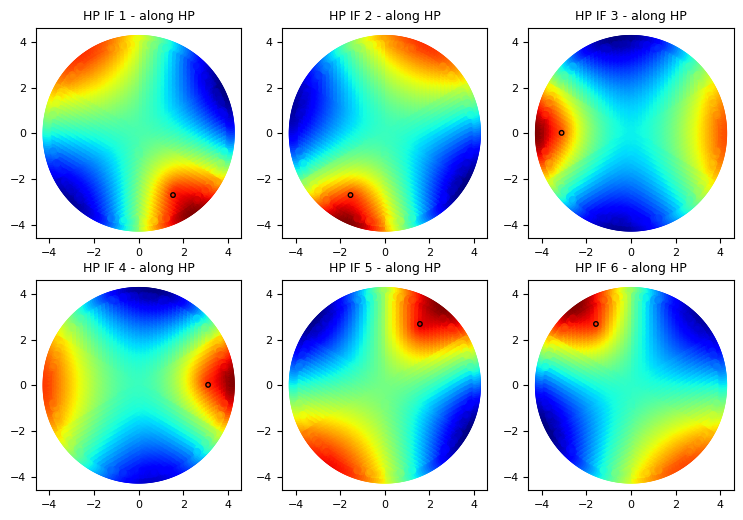

In [7]:
nrow = 2
fig, ax = plt.subplots(nrow,3,figsize=(9,3*nrow))
i = 0
for HPID in range(1,3*nrow+1):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    i += 1

    img = ax[irow][icol].scatter(nodex, nodey,10, -Afhp[:,HPID-1])
    circle = plt.Circle((hpx[HPID-1], hpy[HPID-1]),0.1, fill=False)
    ax[irow][icol].add_artist(circle)
    ax[irow][icol].tick_params(axis='both', which='major', labelsize=8)
    ax[irow][icol].set_title('HP IF %d - along HP'%HPID, fontsize=9)

### We calculate the surface slopes for the HP IFs

In [8]:
#BM surf nodes (as in the GMT FEA) are not on a regular grid.
# this gives a approximate sense of grid size
np.sqrt(nodex.shape[0])

166.388100536066

In [9]:
pixSize = 50e-3 #50mm, so that 166 pixels cover 8.3m
vec = np.arange(np.min(nodex), np.max(nodex)+pixSize, pixSize)
xfit, yfit = np.meshgrid(vec, vec)
print(xfit.shape)
rfit = np.sqrt(xfit**2+yfit**2)
mask = np.ones_like(rfit)
mask[rfit>np.max(xfit)]=np.nan

(169, 169)


In [10]:
from scipy.interpolate import griddata

done


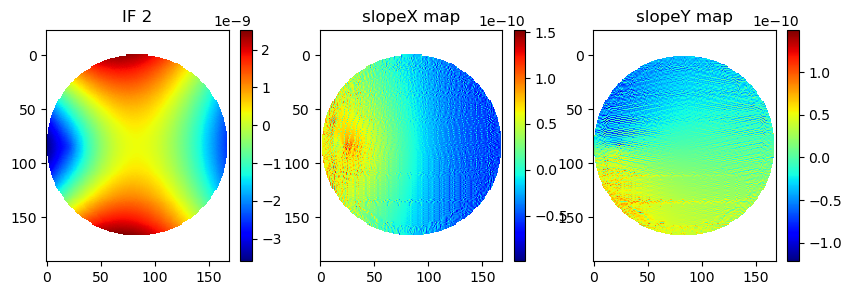

In [11]:
slopeMax = np.zeros(6)
slopeRms = np.zeros(6)
fig, ax = plt.subplots(1,3, figsize=(10,3))
for HPID in np.arange(1,6+1):
    i = HPID-1
    #print(i, end = ' ')
    dd = griddata(np.vstack((nodex, nodey)).T, Afhp[:,HPID-1], (xfit, yfit), method='nearest')
    slopeX = dd*mask - np.roll(dd*mask,1,axis=1)
    slopeY = dd*mask - np.roll(dd*mask,1,axis=0)
    slope = np.sqrt(slopeX**2+slopeY**2)*2 # we want um per 100mm (each pixel is 50mm)

    slopeMax[i] = np.max(slope[~np.isnan(slope)])
    slopeRms[i] = np.sqrt(np.mean((slope[~np.isnan(slope)]**2)))
    #print(slopeMax[i], slopeRms[i], np.std(slope[~np.isnan(slope)]))
    if i==2:
        img = ax[0].imshow(dd*mask)
        ax[0].axis('equal')
        ax[0].set_title('IF %d'%i)
        fig.colorbar(img, ax=ax[0]);

        img = ax[1].imshow(slopeX)
        ax[1].axis('equal')
        ax[1].set_title('slopeX map')
        fig.colorbar(img, ax=ax[1]);
        
        img = ax[2].imshow(slopeY)
        ax[2].axis('equal')
        ax[2].set_title('slopeY map')
        fig.colorbar(img, ax=ax[2]);
print('done')

In [12]:
c = np.ones_like(slopeMax)
c *= 400 #350N force on each
print('HP ID, Unit F (N), F MAX(N), S RMS(nm),    S MAX(nm), slope MAX (nm/100mm), slope RMS (nm/100mm)')
for HPID in np.arange(1,6+1):
    print('%6d, %6.1f, %8.0f,    %8.0f,    %8.0f,      %8.0f,      %8.0f'%(HPID, 
                                                                                  c[HPID-1],
                                                    c[HPID-1], 
                                                   c[HPID-1]*1e9*np.std(Afhp[:,HPID-1]), 
                                                    c[HPID-1]*1e9*np.max(Afhp[:,HPID-1]),
                                                    c[HPID-1]*1e9*slopeMax[HPID-1], 
                                                    c[HPID-1]*1e9*slopeRms[HPID-1]
                                                   ))

HP ID, Unit F (N), F MAX(N), S RMS(nm),    S MAX(nm), slope MAX (nm/100mm), slope RMS (nm/100mm)
     1,  400.0,      400,         387,         861,           107,            34
     2,  400.0,      400,         468,        1032,           131,            41
     3,  400.0,      400,         481,        1003,           151,            43
     4,  400.0,      400,         419,         957,           111,            37
     5,  400.0,      400,         389,         891,            93,            34
     6,  400.0,      400,         394,         858,           120,            35


### Hardpoint transformation matrix

HP2XYZ * (HP force vector) = (net forces and moments), confirmed by Trupti by email (9/25/23)

In [13]:
Tmat = np.loadtxt('HP2XYZ.txt') #
Tinv = scipy.linalg.inv(Tmat)

In [14]:
print(Tinv)

[[-0.43921948  0.25950597 -0.22964749  0.10286064 -0.11755587 -0.082392  ]
 [ 0.43921948  0.25950597 -0.22964749  0.10286064  0.11755587  0.082392  ]
 [-0.00512953 -0.51012801 -0.22964749  0.05037505  0.14785722 -0.082392  ]
 [-0.44434901  0.25062204 -0.22964749 -0.15323569  0.03030135  0.082392  ]
 [ 0.44434901  0.25062204 -0.22964749 -0.15323569 -0.03030135 -0.082392  ]
 [ 0.00512953 -0.51012801 -0.22964749  0.05037505 -0.14785722  0.082392  ]]


### If we apply net Fx, Fy, Fz, Mx, My, Mz in turn (not the current plan)

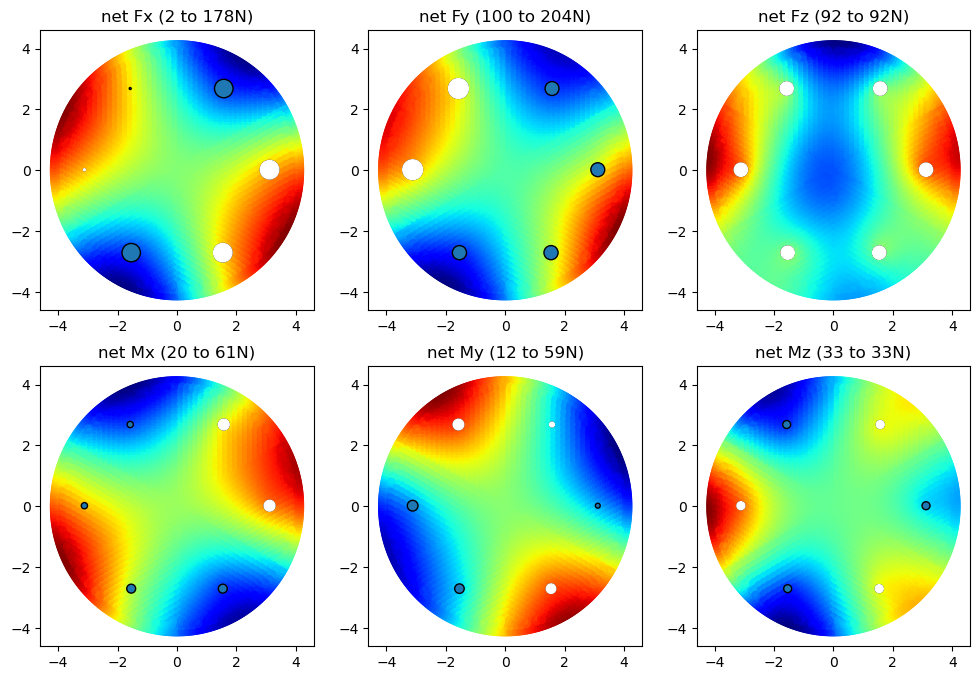

In [15]:
Dstr = ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']
nrow = 2
fig, ax = plt.subplots(nrow,3,figsize=(12,4*nrow))
for i in range(6):
    Dvec = np.zeros(6)
    Dvec[i] = 400 #either 400N or 400N*m
    Fvec = Tinv @ Dvec
    Surf = Afhp @ Fvec
    
    irow = np.int8(i/3)
    icol = np.mod(i,3)

    img = ax[irow][icol].scatter(nodex, nodey,10, Surf)
    img = ax[irow][icol].scatter(hpx, hpy, abs(Fvec), edgecolor='k')
    img = ax[irow][icol].scatter(hpx[Fvec<0], hpy[Fvec<0], abs(Fvec[Fvec<0]), facecolor='w')
    ax[irow][icol].set_title('net %s (%.0f to %.0fN)'%(Dstr[i], min(abs(Fvec)), max(abs(Fvec))))

In [16]:
max(Fvec)

32.95680187194636

### We will apply 400N to each hardpoint in turn, push first, then pull

In [18]:
print('pushes')
print('Fx (N)    Fy (N)     Fz (N)    Mx (N*m)  My (N*m)  Mz (N*m)')
for i in range(6):
    Fvec = np.zeros(6)
    Fvec[i] = 400 #apply 400N to each HP in turn
    demand = -Tmat @ Fvec
    for d in demand:
        print('%8.1f '%d, end = ' ')
    print()
print('pulls')
for i in range(6):
    Fvec = np.zeros(6)
    Fvec[i] = -400 #apply 400N to each HP in turn
    demand = Tmat @ Fvec
    print(demand)  

pushes
Fx (N)    Fy (N)     Fz (N)    Mx (N*m)  My (N*m)  Mz (N*m)
   181.2    -207.1     290.3    -773.8     457.2     809.1  
  -181.2    -207.1     290.3    -773.8    -457.2    -809.1  
    88.7     260.5     290.3      -9.0    -898.7     809.1  
   270.0     -53.4     290.3     782.8    -441.5    -809.1  
  -270.0     -53.4     290.3     782.8     441.5     809.1  
   -88.7     260.5     290.3      -9.0     898.7    -809.1  
pulls
[ 181.208 -207.096  290.3   -773.772  457.172  809.14 ]
[-181.208 -207.096  290.3   -773.772 -457.172 -809.14 ]
[  88.748  260.48   290.3     -9.036 -898.692  809.14 ]
[ 269.956  -53.384  290.3    782.808 -441.52  -809.14 ]
[-269.956  -53.384  290.3    782.808  441.52   809.14 ]
[ -88.748  260.48   290.3     -9.036  898.692 -809.14 ]


What surface shapes these demand vectors produce? of course they produce the HP influence functions shown above.